# Imports

In [8]:
!pip install rectools

  Using cached RecTools-0.3.0-py3-none-any.whl (89 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 KB 518.6 kB/s eta 0:00:0000:0100:01
  Using cached Markdown-3.2.2-py3-none-any.whl (88 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
  Using cached implicit-0.4.4.tar.gz (1.1 MB)
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for implicit: filename=implicit-0.4.4-cp38-cp38-macosx_10_9_x86_64.whl size=950848 sha256=bccdfb7bffe87907f4062689b45b33d6ab305eeacec900103fcab3f4c19d53ca
  Stored in directory: /Users/macbook/Library/Caches/pip/wheels/00/ac/67/6f4536c819ed560c2c7e17c0f7a920e3e50c26108616087d05
Successfully built implicit
You should consider upgrading via the '/Users/macbook/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [326]:
from copy import deepcopy
from tqdm.auto import tqdm
from scipy.stats import mode
from pprint import pprint
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rectools import Columns
from rectools.dataset import Dataset, Interactions
from rectools.models.popular import PopularModel, Popularity
from rectools.models.popular_in_category import PopularInCategoryModel
from rectools.model_selection import TimeRangeSplitter
from rectools.metrics import MAP, Recall, calc_metrics

# Reading data

In [3]:
items = pd.read_csv('items.csv')
items.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [5]:
users = pd.read_csv('users.csv')
users.head(5)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [7]:
interactions = pd.read_csv('interactions.csv')
interactions.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [10]:
interactions.rename(
    columns={
        'item_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [11]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,user_id,item_id
0,3,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
1,11,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
2,29,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
3,30,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
4,33,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
...,...,...
193108,1097527,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
193109,1097537,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
193110,1097538,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
193111,1097544,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."


# Preparing data

In [14]:
_, bins = pd.qcut(items["release_year"], 10, retbins=True)
labels = bins[:-1]

year_feature = pd.DataFrame(
    {
        Columns.Item: items[Columns.Item],
        "value": pd.cut(items["release_year"], bins=bins, labels=bins[:-1]),
        "feature": "release_year",
    }
)
year_feature.head()

,item_id,value,feature
0,10711,1983.0,release_year
1,2508,2012.0,release_year
2,10716,2009.0,release_year
3,7868,2014.0,release_year
4,16268,1897.0,release_year


In [15]:
items["genre"] = items["genres"].str.split(",")
items[["genre", "genres"]].head(3)

,genre,genres
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы"
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии"
2,"[криминал, зарубежные, триллеры, боевики, ...","криминал, зарубежные, триллеры, боевики, комедии"


In [16]:
genre_feature = items[[Columns.Item, "genre"]].explode("genre")
genre_feature.columns = [Columns.Item, "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,item_id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [17]:
item_feat = pd.concat([genre_feature, year_feature])
item_feat = item_feat[item_feat[Columns.Item].isin(interactions[Columns.Item])]

In [304]:
interactions

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76.0,0.0
5476247,546862,9673,2021-04-13,2308.0,49.0
5476248,697262,15297,2021-08-20,18307.0,63.0
5476249,384202,16197,2021-04-19,6203.0,100.0


In [ ]:
inters = Interactions(interactions)

In [ ]:
n_folds = 3
unit = "D"
n_units = 7
#last_date = interactions[Columns.Datetime].max().normalize()
last_date = pd.to_datetime('15-08-2021', format='%d-%m-%Y')
start_date = last_date - pd.Timedelta(n_folds * n_units - 1, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"
date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
date_range

In [ ]:
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
)

## function for model selection

In [311]:
def select_model(simple_model, params, cv=cv, inters=inters, K_RECOS=10):
    metrics = {
        "Recall@10": Recall(k=10),
        "MAP@10": MAP(k=10),
    }
    values = [param for param in params.values()]
    values = list(product(*values))
    #print(values)

    fold_iterator = cv.split(inters)
    results =[]

    pbar = tqdm(enumerate(fold_iterator), total=cv.get_n_splits(inters))

    for i_fold, (train_ids, test_ids, _) in pbar:     
        pbar.set_description(f'Fold#{i_fold}')
        
        df_train = inters.df.iloc[train_ids]
        item_feat_train = item_feat[item_feat[Columns.Item].isin(df_train[Columns.Item])]
        
        dataset = Dataset.construct(
            interactions_df=df_train,
            user_features_df=None,
            item_features_df=item_feat_train,
            cat_item_features=['genre', 'release_year']
        )

        df_test = inters.df.iloc[test_ids][Columns.UserItem]
        test_users = np.unique(df_test[Columns.User])
        for i in range(len(values)):
            #print(values[i])
            model = deepcopy(simple_model)
            for j, param in enumerate(params):
                setattr(model, param, values[i][j])
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(
                metrics,
                reco=recos,
                interactions=df_test,
                prev_interactions=df_train
            )
            res = {"fold": i_fold, "model": repr(values[i])}
            res.update(metric_values)
            results.append(res)

    return results

In [228]:
sample_submission = pd.read_csv('sample_submission.csv')

# Construct dataset

In [313]:
dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=None,
    item_features_df=item_feat,
    cat_item_features=['genre', 'release_year']
)

# Popular model

## simple popular model

In [19]:
popular = PopularModel()
popular.fit(dataset)
popular.recommend(
    dataset.user_id_map.external_ids[:1], 
    dataset=dataset, 
    k=10, 
    filter_viewed=False
).merge(items[['item_id', 'title']], 
       on='item_id',
       how='left')

,user_id,item_id,score,rank,title
0,176549,10440,202457.0,1,Хрустальный
1,176549,15297,193123.0,2,Клиника счастья
2,176549,9728,132865.0,3,Гнев человеческий
3,176549,13865,122119.0,4,Девятаев
4,176549,4151,91167.0,5,Секреты семейной жизни
5,176549,3734,74803.0,6,Прабабушка легкого поведения
6,176549,2657,68581.0,7,Подслушано
7,176549,4880,55043.0,8,Афера
8,176549,142,45367.0,9,Маша
9,176549,6809,40372.0,10,Дуров


## finding the best popular model

In [104]:
params = {
    'period':[None, pd.Timedelta(7, unit='d'), pd.Timedelta(14, unit='d'), pd.Timedelta(28, unit='d')],
    'popularity': [Popularity.N_USERS, Popularity.MEAN_WEIGHT, Popularity.SUM_WEIGHT]
}

In [105]:
results = select_model(popular, params, cv, inters)

Fold#2: 100%|██████████| 3/3 [03:44<00:00, 74.79s/it]


In [107]:
results = pd.DataFrame(results)
results.groupby(by='model').agg({'Recall@10': 'mean', 'MAP@10': 'mean'}).sort_values(by=['MAP@10', 'Recall@10'])

,Recall@10,MAP@10
model,,
"(None, <Popularity.MEAN_WEIGHT: 'mean_weight'>)",0.000012,0.000003
"(Timedelta('28 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)",0.000148,0.000084
"(Timedelta('7 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)",0.000276,0.000131
"(Timedelta('14 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>)",0.000155,0.000132
"(Timedelta('7 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)",0.159181,0.074741
"(Timedelta('14 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)",0.167687,0.075863
"(Timedelta('28 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>)",0.178331,0.079610
"(None, <Popularity.SUM_WEIGHT: 'sum_weight'>)",0.170281,0.080575
"(None, <Popularity.N_USERS: 'n_users'>)",0.181478,0.087539


# predict results with the best popular model

In [111]:
popular = PopularModel(period=pd.Timedelta(7, unit='d'), popularity=Popularity.N_USERS)
popular.fit(dataset)

In [128]:
res = popular.recommend(
    dataset.user_id_map.external_ids[:1], 
    dataset=dataset, 
    k=10, 
    filter_viewed=False
).merge(items[['item_id', 'title']], 
       on='item_id',
       how='left')
res

,user_id,item_id,score,rank,title
0,176549,10440,18004.0,1,Хрустальный
1,176549,15297,15099.0,2,Клиника счастья
2,176549,9728,14326.0,3,Гнев человеческий
3,176549,7793,7168.0,4,Радиовспышка
4,176549,13865,6905.0,5,Девятаев
5,176549,12192,6755.0,6,Фемида видит
6,176549,3734,6086.0,7,Прабабушка легкого поведения
7,176549,11863,6078.0,8,Девятаев - сериал
8,176549,4151,5973.0,9,Секреты семейной жизни
9,176549,5434,3802.0,10,История семьи Блум


In [125]:
res = list(res.item_id)

In [229]:
popular_res = sample_submission.copy()

In [230]:
popular_res.item_id = "[" + ", ".join(map(str, res.item_id.to_list())) + "]"

In [145]:
popular_res.to_csv('popular_submission.csv', index=False)

submited the results, map@10 is not much lower

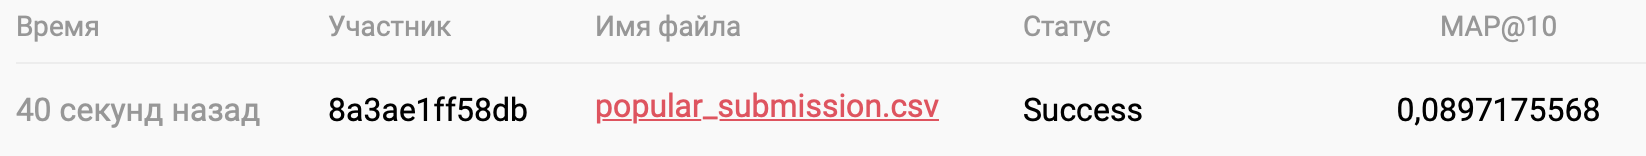

# Popular in category model on item feature

In [164]:
popular_cat = PopularInCategoryModel(category_feature='genre')
params = {
    'period':[None, pd.Timedelta(7, unit='d')],
    'popularity': [Popularity.N_USERS, Popularity.MEAN_WEIGHT, Popularity.SUM_WEIGHT],
    'n_categories': [3, 5, 10]
    }

In [167]:
results = select_model(popular_cat, params, cv, inters)

Fold#2: 100%|██████████| 3/3 [53:02<00:00, 1060.87s/it]


In [169]:
results = pd.DataFrame(results)
results.groupby(by='model').agg({'Recall@10': 'mean', 'MAP@10': 'mean'}).sort_values(by=['MAP@10', 'Recall@10'])

,Recall@10,MAP@10
model,,
"(None, <Popularity.MEAN_WEIGHT: 'mean_weight'>, 3)",0.000015,0.000007
"(None, <Popularity.MEAN_WEIGHT: 'mean_weight'>, 5)",0.000094,0.000027
"(None, <Popularity.MEAN_WEIGHT: 'mean_weight'>, 10)",0.000096,0.000027
"(Timedelta('7 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>, 10)",0.000310,0.000109
"(Timedelta('7 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>, 5)",0.000303,0.000114
"(Timedelta('7 days 00:00:00'), <Popularity.MEAN_WEIGHT: 'mean_weight'>, 3)",0.000607,0.000158
"(Timedelta('7 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>, 3)",0.115297,0.060353
"(None, <Popularity.SUM_WEIGHT: 'sum_weight'>, 3)",0.111912,0.061688
"(Timedelta('7 days 00:00:00'), <Popularity.SUM_WEIGHT: 'sum_weight'>, 5)",0.117861,0.062499


Best params are N_users popularity, week period, 10 categories

# predict results with the best popular in category model

In [183]:
popular_cat = PopularInCategoryModel(
    category_feature='genre', 
    period=pd.Timedelta(7, unit='d'), 
    popularity=Popularity.N_USERS,
    n_categories=10
    )
popular_cat.fit(dataset)

for those users who is not in our dataset we will use recommendations of our previous model

In [249]:
popular_cat_res = popular_res.copy()

In [235]:
is_warm = popular_cat_res.user_id.isin(dataset.user_id_map.external_ids)

In [236]:
rec = popular_cat.recommend(
    popular_cat_res.user_id[is_warm], 
    dataset=dataset, 
    k=10, 
    filter_viewed=False
)

In [237]:
grouped_rec = rec.groupby(by='user_id').agg({'item_id': list}).reset_index()

In [275]:
grouped_rec = grouped_rec.set_index(popular_cat_res.loc[is_warm, 'item_id'].index)

In [276]:
popular_cat_res.loc[is_warm, 'item_id']= grouped_rec.item_id

In [278]:
popular_cat_res

,user_id,item_id
0,3,"[15297, 9728, 12192, 13865, 10440, 7793, 7829,..."
1,11,"[15297, 9728, 12192, 13865, 10440, 7793, 7829,..."
2,29,"[10440, 15297, 9728, 7793, 13865, 12192, 3734,..."
3,30,"[15297, 9728, 12192, 13865, 10440, 7793, 7829,..."
4,33,"[10440, 15297, 9728, 7793, 13865, 12192, 3734,..."
...,...,...
193108,1097527,"[10440, 15297, 9728, 7793, 13865, 12192, 3734,..."
193109,1097537,"[10440, 15297, 9728, 7793, 13865, 12192, 3734,..."
193110,1097538,"[10440, 15297, 9728, 7793, 13865, 12192, 3734,..."
193111,1097544,"[15297, 9728, 12192, 13865, 10440, 7793, 7829,..."


In [279]:
popular_cat_res.to_csv('popular_in_category_submission.csv', index=False)

Submission results

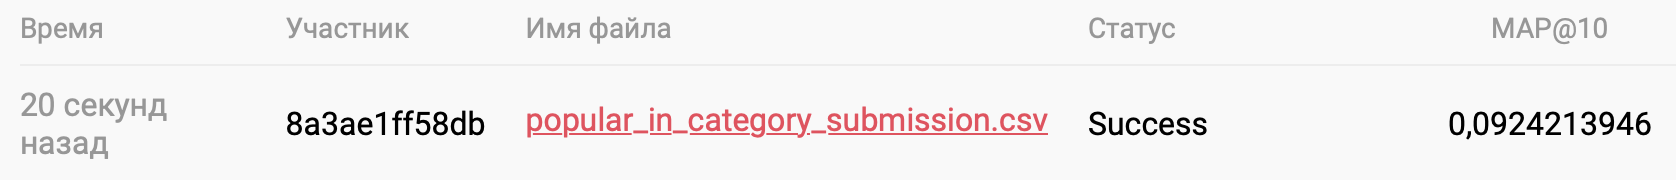

# Popular covered by n% of unique users

In [281]:
matrix = dataset.get_user_item_matrix()

In [282]:
def get_top_items_covered_users(matrix, n_users=1000):
    
    assert matrix.format == 'csr'

    item_set = []
    covered_users = np.zeros(matrix.shape[0], dtype=bool)
    while covered_users.sum() < n_users: 
        top_item = mode(matrix[~covered_users].indices)[0][0] 
        item_set.append(top_item)
        covered_users += np.maximum.reduceat(matrix.indices==top_item, matrix.indptr[:-1], dtype=bool) 
    return item_set, covered_users

In [283]:
item_set, covered_users = get_top_items_covered_users(matrix, n_users=600000)

In [284]:
pop_covered = dataset.item_id_map.convert_to_external(item_set) 
pop_covered

array([10440, 15297,  9728, 13865,  2657,  4151,  6809,  4740,  3734,
        4880, 11237,  8636,  7571, 14741,  1844, 14431,  9996,  7626,
         142,   849,  4436, 16166,  4457, 11863, 13018, 12192,  4495,
         101,  7107,  4685])

In [285]:
pd.DataFrame(pop_covered, columns=['item_id']).merge(items[['item_id', 'title']], 
        on='item_id',
        how='left').head(10)

,item_id,title
0,10440,Хрустальный
1,15297,Клиника счастья
2,9728,Гнев человеческий
3,13865,Девятаев
4,2657,Подслушано
5,4151,Секреты семейной жизни
6,6809,Дуров
7,4740,Сахаров. Две жизни
8,3734,Прабабушка легкого поведения
9,4880,Афера


In [298]:
popular_cov_res = sample_submission.copy()
popular_cov_res.item_id = "[" + ", ".join(map(str, pop_covered[:10])) + "]"

In [299]:
popular_cov_res.to_csv('popular_covered_submission.csv', index=False)

Submission results

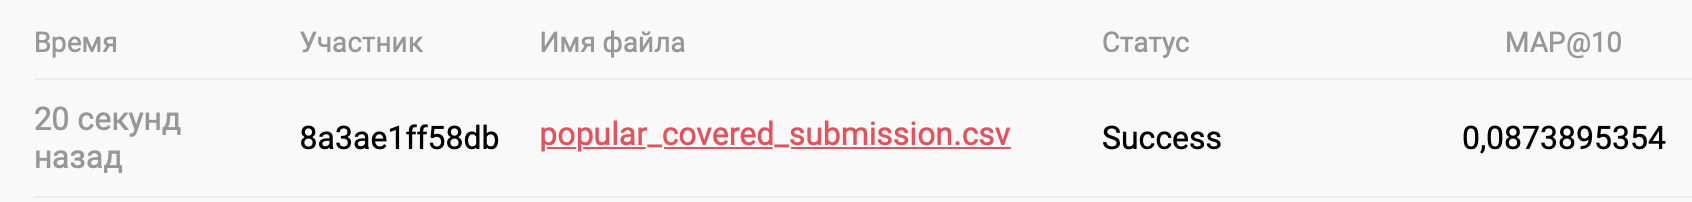

# Visualisation of results

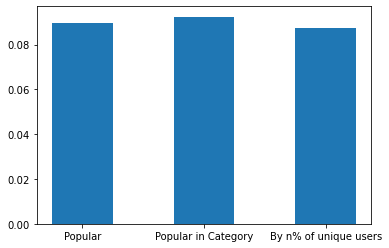

In [316]:
models = np.array(["Popular", "Popular in Category", "By n% of unique users"])
scores = np.array([0.089717, 0.092421, 0.087389])

plt.bar(models, scores, width=0.5)
plt.show()

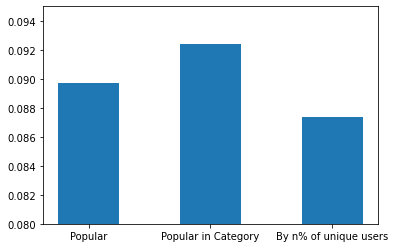

In [320]:
plt.bar(models, scores, width=0.5)
plt.ylim(0.08, 0.095)
plt.show()

Maybe popular in Category is the best of these three models beacause this model uses results of popular model